In [1]:
!pip install -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics

     |████████████████████████████████| 296kB 3.4MB/s 
     |████████████████████████████████| 6.7MB 8.5MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 2.1MB 55.1MB/s 
     |████████████████████████████████| 12.8MB 348kB/s 
     |████████████████████████████████| 110.5MB 48kB/s 
     |████████████████████████████████| 512kB 45.8MB/s 
     |████████████████████████████████| 3.8MB 45.6MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... 

In [0]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 


In [0]:
def attach_sp_calc(image):
  "Converts image calculator to single point calculator to avoid double calculation."
  sample_energy = image.get_potential_energy(apply_constraint=False)
  sample_forces = image.get_forces(apply_constraint=False)
  image.set_calculator(
      sp(atoms=image, energy=sample_energy, forces=sample_forces)
  )
  return image

class CounterCalc(Calculator):
  "ASE calculator to track the number of force calls the parent calculator has performed"
  implemented_properties = ["energy", "forces"]

  def __init__(self, calc):
    """Parameters
    --------------
      calc: object. Parent calculator to track force calls."""
    super().__init__()
    self.calc = calc
    self.force_calls = 0

  def calculate(self, atoms, properties, system_changes):
    super().calculate(atoms, properties, system_changes)
    calc = copy.deepcopy(self.calc)
    self.results["energy"] = calc.get_potential_energy(atoms)
    self.results["forces"] = calc.get_forces(atoms)
    self.force_calls += 1


class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()

      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 

      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      """
    def get_trajectory(self, filename, start_count, end_count, interval):
      trajectory = ase.io.read(
        filename + ".traj", "{}:{}:{}".format(start_count, end_count, interval)
      )
      return trajectory

In [0]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc)
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    qn = QuasiNewton(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    qn = QuasiNewton(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

In [15]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "O": {"re": 1.09, "D": 8.575, "sig": 0.603},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

# Training parameters for the active learning framework
training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 5},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 1,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 200,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "neb_example",
      "file_dir": "./"
}

ml2relax = False
parent_calc = EMT()
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
images = [initial]
images.append(final)

# Define AL scheme

learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=parent_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

learner.learn(
    atomistic_method=NEBcalc(
        starting_images=images, 
        ml2relax=ml2relax, 
        intermediate_samples=total_neb_images-2), 
		query_strategy=random_query
	)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0940         47.4839       90.1977     +  0.0952
      2          0.0925         13.0982        6.8711     +  0.1143
      3          0.0921          6.4845        1.6904     +  0.1293
      4          0.0917          4.2251        0.7224     +  0.1516
      5          0.0898          3.4430        0.4823     +  0.1490
      6          0.0845          2.0548        0.1760     +  0.1618
      7          0.0830          1.8266        0.1404     +  0.1635
      8          0.0738          1.6499        0.1143     +  0.1625
      9          0.0441          1.2002        0.0596     +  0.1625
     10          0.0394          1.1226        0.0520     +  0.1826
     11          0.0340          1.0750        0.0474     +  0.1643
     12          0.0313          1.0675        0.0466     +  0.

Visualize AL Results

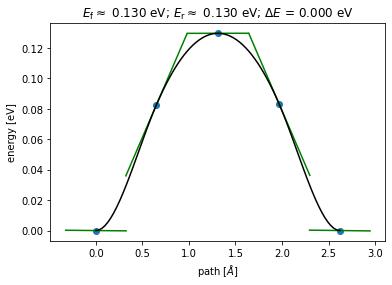

In [6]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE, max_force

images = read(f'neb_example_iter_{training_params["al_convergence"]["num_iterations"]}.traj@-{total_neb_images}:')

# to verify ml_computed images...evaluate with parent calculator
emt_evaluated_images = []
for image in images:
  #image = image.copy()
  image.set_calculator(EMT())
  emt_evaluated_images.append(image)

barrier_ml, dE_ml, max_force_ml = neb_analysis(images, label="ml_diffusion_neb")

ML barrier pred = 0.12953178708526455, ml dE pred = 1.082219940196083e-05, ml max force = 0.01633167628926707
emt@ml barrier = 0.12953178708526455, emt@ml dE = 1.082219940196083e-05, emt@ml max force = 0.01633167628926707
AL: Total number of force calls = 31 (initial data) + 20 (AL-NEB) = 51


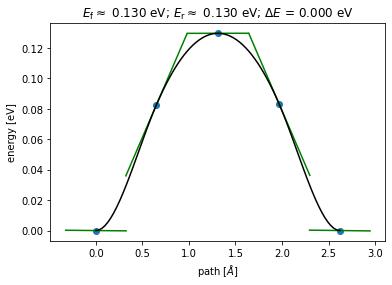

In [7]:
barrier_emt_ml, dE_emt_ml, max_force_emt_ml = neb_analysis(emt_evaluated_images, label="emt@ml_diffusion_neb")
print(f"ML barrier pred = {barrier_ml}, ml dE pred = {dE_ml}, ml max force = {max_force_ml}")
print(f"emt@ml barrier = {barrier_emt_ml}, emt@ml dE = {dE_emt_ml}, emt@ml max force = {max_force_emt_ml}")
print(f"AL: Total number of force calls = {initial_force_calls} (initial data) + {learner.parent_calls} (AL-NEB) = {initial_force_calls+learner.parent_calls}")

#### Code to generate true NEB

In [8]:
emt_counter = CounterCalc(EMT())

if not ml2relax:
  # Load previously computed relaxed states
  initial_slab = read("initial.traj", "-1")
  final_slab = read("final.traj", "-1")
else:
  initial.set_calculator(emt_counter)
  final.set_calculator(emt_counter)
  qn = QuasiNewton(initial, trajectory='parent_initial.traj', logfile='initial_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  qn = QuasiNewton(final, trajectory='parent_final.traj', logfile='final_relax_log.txt')
  qn.run(fmax=0.01, steps=200)
  initial_slab = read("parent_initial.traj", "-1")
  final_slab = read("parent_final.traj", "-1")

images = [initial]
for i in range(3):
    image = final.copy()
    image.set_calculator(emt_counter)
    images.append(image)
images.append(final)

neb = SingleCalculatorNEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb.traj')
qn.run(fmax=0.01)

      Step     Time          Energy         fmax
BFGS:    0 23:51:33        4.222858        4.3067
BFGS:    1 23:51:33        3.947671        2.8886
BFGS:    2 23:51:33        3.793445        1.7838
BFGS:    3 23:51:33        3.721149        0.9349
BFGS:    4 23:51:33        3.697492        0.3497
BFGS:    5 23:51:34        3.690960        0.4067
BFGS:    6 23:51:34        3.676023        0.4033
BFGS:    7 23:51:34        3.665892        0.2970
BFGS:    8 23:51:34        3.660757        0.1845
BFGS:    9 23:51:34        3.659329        0.1570
BFGS:   10 23:51:34        3.658204        0.1398
BFGS:   11 23:51:35        3.656267        0.1019
BFGS:   12 23:51:35        3.655090        0.0763
BFGS:   13 23:51:35        3.654954        0.0357
BFGS:   14 23:51:35        3.654962        0.0185
BFGS:   15 23:51:35        3.654946        0.0132
BFGS:   16 23:51:35        3.654933        0.0075


True

Ef = 0.12946476907802576, dE = 1.082219940196083e-05, max_force = 0.007450782039978097
Total number of force calls = 31 (initial data) + 51 Total = 82


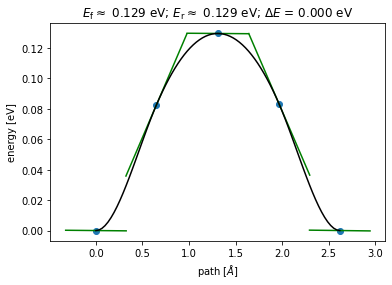

In [9]:
images = read(f'actual_neb.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE, max_force = neb_analysis(images, label="actual_emt_neb")

print(f"Ef = {Ef}, dE = {dE}, max_force = {max_force}")
print(f"Total number of force calls = {initial_force_calls} (initial data) + {emt_counter.force_calls} Total = {initial_force_calls+emt_counter.force_calls}")